<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.982 · TFM Àrea 5</p>
<p style="margin: 0; text-align:right;">2025/26 Màster Universitari en Ciència de Dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-bottom: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Gestió proactiva de la demanda en Atenció Precoç - Models de predicció amb xarxes neuronals (LSTM i MV-LSTM)



Un cop avaluats els models ARIMA i SARIMA, i observats els amplis intervals de confiança, es procura explorar altres models.

En aquesta última secció s'exploren dos models d'aprenentatge profund, ambdós basats en xarxes neuronals recurrents (RNN), concretament les xarxes del tipus Long Short-Term Memory (LSTM), dissenyades per aprendre i recordar patrons en una seqüència temporal. Els models que es dissenyaran són els següents:

- LSTM univariant: Xarxa neuronal dissenyada per aprendre i recordar patrons en una seqüència temporal. Està formada per una cèl·lula de memòria i tres portes: d'entrada, de sortida i d'oblit, que regulen el flux d'informació, decidint quina informació es manté en la memòria i quina s'oblida. Aquestes portes també solucionen problemes comuns de les RNN tradicionals, com l'esvaïment i l'explosió de gradient, els quals dificulten l'aprenentatge de les dependències a llarg termini en les sèries temporals. S'utilitza per diversos problemes de classificació, anàlisi de sèries temporals, traducció automàtica d'idiomes, entre altres aplicacions.
- MV-LSTM (Multi-Variate LSTM): Extensió de la LSTM tradicional univariant, específicament dissenyada per l'ajustament sobre sèries temporals amb variables externes (exògenes), que són variables explicatives que poden influir en el fenomen estudiat. Aquesta informació pot millorar la precisió del model.

In [4]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")
sns.set_context("notebook") 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
with open('../dades/df_cdiap_raw_2020_25.pkl', 'rb') as f:
    data_cdiap = pickle.load(f)

## 1. Creació de la xarxa neuronal LSTM

Al modelatge amb ARIMA es va observar una millora en la predicció quan la demanda era setmanal. 

Per aquest motiu, i perquè la demanda mensual és una granularitat massa alta si es prenen les observacions entre 2020 i 2025 (només 72 observacions), es fa l'agrupació setmanal igual que a l'últim model SARIMA:

In [8]:
ts_demanda_cdiap = (
    data_cdiap
    .set_index("Data de demanda")  # Posem la data com a índex
    .resample("W-MON")             # Remostrejem per setmana
    .size()                        
    .fillna(0)                     # IMPORTANT: Hi ha setmanes buides, definim amb 0
)

df_LSTM = ts_demanda_cdiap.to_frame(name="demanda")

df_LSTM.head()

,demanda
Data de demanda,
2020-01-13,12
2020-01-20,9
2020-01-27,10
2020-02-03,10
2020-02-10,13


S'inicia la preparació de les dades per la creació del primer model:

In [10]:
# Al ser sèrie temporal no es barreja el conjunt de dades
train_size = int(len(df_LSTM) * 0.8)

train_df_LSTM = df_LSTM.iloc[:train_size]
test_df_LSTM = df_LSTM.iloc[train_size:]

In [11]:
# Es normalitzen els valors
scaler = MinMaxScaler()

train_scaled_LSTM = scaler.fit_transform(train_df_LSTM[["demanda"]])
test_scaled_LSTM = scaler.transform(test_df_LSTM[["demanda"]])

In [12]:
# Es creen les seqüències temporals. 
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Definim les finestres d'entrada per entrenar al model de forma anual
window_size = 12

X_train_LSTM, y_train_LSTM = create_sequences(train_scaled_LSTM, window_size)
X_test_LSTM, y_test_LSTM = create_sequences(test_scaled_LSTM, window_size)

In [13]:
print(X_train_LSTM.shape) 
print(y_train_LSTM.shape) 

(236, 12, 1)
(236, 1)


S'obtenen 192 seqüències de 12 passos amb la demanda per el subconjunt "X", i per "Y" 196 amb l'objectiu de la demanda.

Es procedeix al disseny de la LSTM, amb l’optimitzador Adam i la funció de pèrdua Mean Squared Error (MSE), ja que aquest tipus d’arquitectura és especialment adequada per al tractament de sèries temporals, com és el cas que es tracta.

In [16]:
# Disseny de la xarxa neuronal
input_layer = Input(shape=(window_size, 1))
lstm_layer = LSTM(units=100)(input_layer)
output_layer = Dense(1)(lstm_layer)

lstm_model = Model(inputs=input_layer, outputs=output_layer, name="LSTM")

lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.summary()

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Durant l’entrenament del model s’ha incorporat el mecanisme d’early stopping, monitorant la pèrdua de validació (val_loss), per evitar el sobreajustament, que permet aturar l’entrenament quan no s’observen millores després de 10 èpoques consecutives, restaurant els pesos corresponents a la millor iteració obtinguda.

In [18]:
early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=10, 
    restore_best_weights=True,
    verbose=0
)

history_lstm = lstm_model.fit(
    X_train_LSTM,
    y_train_LSTM,
    epochs=100,
    batch_size=16,
    validation_data=(X_test_LSTM, y_test_LSTM),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1007 - val_loss: 0.0609
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0452 - val_loss: 0.0566
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0447 - val_loss: 0.0554
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0419 - val_loss: 0.0543
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0374 - val_loss: 0.0537
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0411 - val_loss: 0.0533
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0454 - val_loss: 0.0526
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0416 - val_loss: 0.0532
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0371 - val_loss: 0.0527
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0390 - val_loss: 0.0520
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0359 - val_loss: 0.0512
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

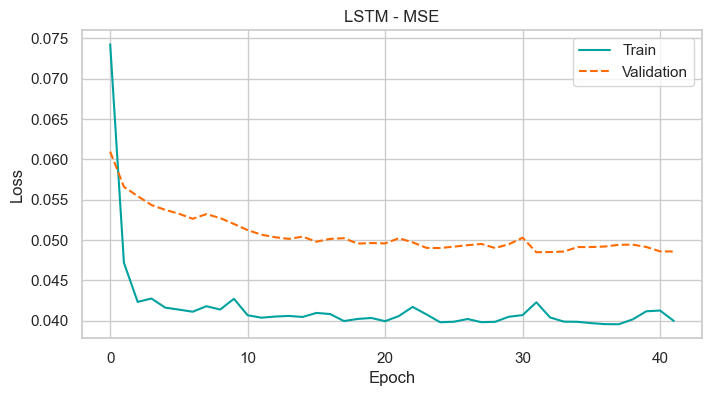

In [19]:
def plot_loss_MSE(history, model_name="Model"):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history["loss"], label="Train", color="#00a2a0")
    plt.plot(history.history["val_loss"], label="Validation", linestyle="dashed", color="#ff6b00")
    plt.title(f"{model_name} - MSE")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_loss_MSE(history_lstm, "LSTM")


A la gràfica de pèrdues a entrenament (train) i validació (validation), s'observen altes al principi, però cauen a les primeres èpoques. El model aprèn de manera efectiva.
Després de la 15a època convergeix, no aconsegueix generalitzar més.
La diferència entre línies denota un lleuger sobreajustament.

In [21]:
y_pred_scaled_LSTM = lstm_model.predict(X_test_LSTM)

y_pred_LSTM = scaler.inverse_transform(y_pred_scaled_LSTM)
y_test_inv_LSTM = scaler.inverse_transform(y_test_LSTM)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [22]:
mae = mean_absolute_error(y_test_inv_LSTM, y_pred_LSTM)
print(f"Error Absolut Mitjà (MAE): {mae:.2f}")

mse = mean_squared_error(y_test_inv_LSTM, y_pred_LSTM)
print(f"Error Quadràtic Mitjà (MSE): {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Arrel de l'Error Quadràtic Mitjà (RMSE): {rmse:.2f}")

r2 = r2_score(y_test_inv_LSTM, y_pred_LSTM)
print(f"Coeficient de Determinació (R²): {r2:.2f}")

Error Absolut Mitjà (MAE): 3.89
Error Quadràtic Mitjà (MSE): 23.47
Arrel de l'Error Quadràtic Mitjà (RMSE): 4.84
Coeficient de Determinació (R²): 0.16


El model s'equivoca de mitjana en 3.88 demandes setmanals, si s'observa l'error estàndard és de 4,87 demandes per setmana, la diferència amb el MAE indica errors grans ocasionals.

Finalment, el model només explica el 15% total de la variabilitat.

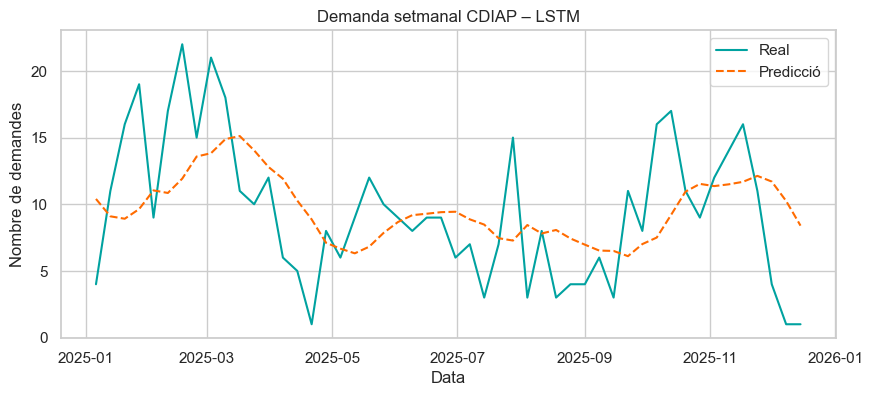

In [24]:
def plot_predictions(test_df, y_real, y_pred, window_size, model_name="Model"):
    plt.figure(figsize=(10, 4))
    plt.plot(test_df.index[window_size:], y_real, label="Real", color="#00a2a0")
    plt.plot(test_df.index[window_size:], y_pred, label="Predicció", linestyle="dashed", color="#ff6b00")
    plt.title(f"Demanda setmanal CDIAP – {model_name}")
    plt.xlabel("Data")
    plt.ylabel("Nombre de demandes")
    plt.legend()
    plt.show()

plot_predictions(test_df_LSTM, y_test_inv_LSTM, y_pred_LSTM, window_size, "LSTM")

En aquest gràfic de la predicció pel 2025 s'observa com el model segueix la tendència general de la demanda. El nivell mitjà és estable, però també és més suau la línia de predicció, no aconsegueix capturar els mínims i els màxims.

El model reacciona a  les 12  setmanes anteriors, per tant, és probable que no capti la forta estacionalitat de les dades.

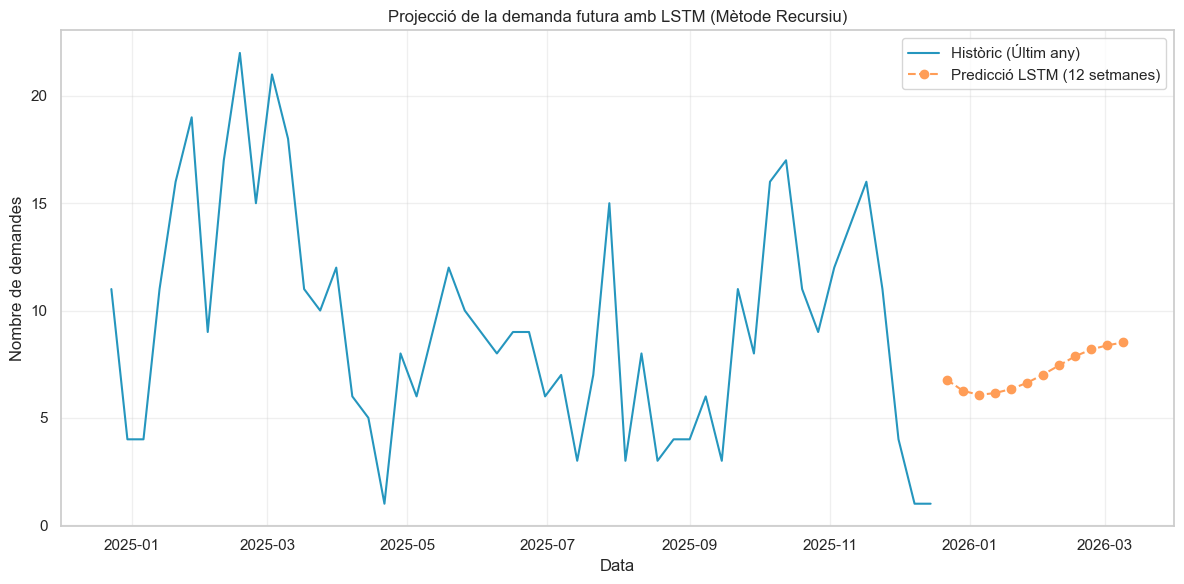

            Predicció
2025-12-22   6.783491
2025-12-29   6.265194
2026-01-05   6.071789
2026-01-12   6.151990
2026-01-19   6.342060
2026-01-26   6.629768
2026-02-02   7.018138
2026-02-09   7.444207
2026-02-16   7.869718
2026-02-23   8.188049
2026-03-02   8.381316
2026-03-09   8.513680


In [26]:
last_sequence = test_scaled_LSTM[-window_size:]
current_sequence = last_sequence.reshape((1, window_size, 1))

future_predictions = []
forecast_steps = 12  # Predir 12 setmanes al futur

# 2. Bucle recursiu
for _ in range(forecast_steps):
    # Predir el següent pas
    next_pred_scaled = lstm_model.predict(current_sequence, verbose=0)
    
    # Guardar la predicció
    future_predictions.append(next_pred_scaled[0, 0])
    
    # Actualitzar la seqüència: 
    next_step = next_pred_scaled.reshape((1, 1, 1))
    current_sequence = np.append(current_sequence[:, 1:, :], next_step, axis=1)

# S'inverteix l'escalat per tenir nombres reals de demandes
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_inv = scaler.inverse_transform(future_predictions)

last_date = test_df_LSTM.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(weeks=1), 
    periods=forecast_steps, 
    freq="W-MON" # Important: Mantenir la freqüència setmanal
)

# Generació de la gràfica
plt.figure(figsize=(12, 6))

plt.plot(df_LSTM.index[-52:], df_LSTM["demanda"].iloc[-52:], label="Històric (Últim any)", color="#2596be")

# Predicció futura
plt.plot(future_dates, future_predictions_inv, label=f"Predicció LSTM ({forecast_steps} setmanes)", color="#ff9d57", linestyle="--", marker='o')

plt.title("Projecció de la demanda futura amb LSTM (Mètode Recursiu)")
plt.xlabel("Data")
plt.ylabel("Nombre de demandes")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

df_future_LSTM = pd.DataFrame(data=future_predictions_inv, index=future_dates, columns=["Predicció"])
print(df_future_LSTM)

Mitjançant el mètode recursiu, es prova de fer una projecció de la demanda a 12 setmanes vista. El model és incapaç de predir els pics i valls propis de l'estacionalitat de les dades. La predicció s'aplana ràpidament cap a la mitjana històrica, ignorant els patrons volàtils. Això es deu a l'error acumulat, fet que dificulta la planificació.

El model LSTM univariant ha extret la informació de l'històric de la demanda tal com es veu a la gràfica de pèrdues, tot i això, com es veu en les prediccions, el model subestima els pics i sobreestima les valls. Fet que fa palès el límit d'aquest model, ja que aquesta variabilitat respon a factors temporals externs que no poden ser capturats només mirant l'històric. Com es veu pel coeficient de determinació, el model és completament incapaç d'explicar la gran part de la variabilitat.

És probable que per la poca quantitat de dades de què disposem per l'entrenament la xarxa sigui conservadora per a minimitzar l'error quadràtic mitjà, convergint cap a la mitjana mòbil en comptes de predir els valors atípics.

Per aquesta raó, en la següent secció s'explora el model multivariant amb la inclusió de variables exògenes.

## 2. Creació de la xarxa neuronal MV-LSTM

Es procedeix a la creació de la xarxa MV-LSTM. Donada la forta estacionalitat detectada en l'EDA i que hem vist capturada pel model SARIMA, en aquest model passarem a afegir variables exògenes deterministes: el mes i la setmana de l'any. Per així poder fer una inferència associada al moment temporal.

Es prescindeix de l'ús d'altres variables sociodemogràfiques (com la població, el codi postal, l'edat a la demanda o el país d'origen), ja que, sense segmentació prèvia, la seva inclusió massiva incrementaria el risc de sobreajustament i una complexitat excessiva per a la matriu d'entrada.

El conjunt de dades conté només 2701 registres, que amb l'agregació setmanal es queda a 310 entrades.
Utilitzar moltes codificacions categòriques (one-hot) podrien desviar la xarxa del patró real i centrar-se en el soroll, i són moltes variables molt granulars per a la predicció del petit volum.

Ens centrem en les variables temporals per a una millor robustesa i generalització.

In [32]:
df_MV_LSTM = ts_demanda_cdiap.to_frame(name="demanda")

# Les variables exògenes serán el mes i la setmana de l'any
df_MV_LSTM["mes"] = df_MV_LSTM.index.month
df_MV_LSTM["setmana_any"] = df_MV_LSTM.index.isocalendar().week.astype(int)

df_MV_LSTM.head()

,demanda,mes,setmana_any
Data de demanda,,,
2020-01-13,12,1,3
2020-01-20,9,1,4
2020-01-27,10,1,5
2020-02-03,10,2,6
2020-02-10,13,2,7


In [33]:
train_size = int(len(df_MV_LSTM) * 0.8)
train_df_MV_LSTM = df_MV_LSTM.iloc[:train_size]
test_df_MV_LSTM = df_MV_LSTM.iloc[train_size:]

# Normalització
# Scaler per a totes les columnes (inputs: demanda, mes, setmana)
scaler_X = MinMaxScaler()
train_X_scaled_LSTM = scaler_X.fit_transform(train_df_MV_LSTM)
test_X_scaled_LSTM = scaler_X.transform(test_df_MV_LSTM)

# Scaler només per a la columna objectiu (demanda) per poder fer la inversa després
scaler_y = MinMaxScaler()
train_y_scaled_MV_LSTM = scaler_y.fit_transform(train_df_MV_LSTM[['demanda']])
test_y_scaled_MV_LSTM = scaler_y.transform(test_df_MV_LSTM[['demanda']])

In [34]:
def create_sequences_mv(data_X, data_y, window_size):
    X, y = [], []
    for i in range(len(data_X) - window_size):
        X.append(data_X[i:(i + window_size)])
        y.append(data_y[i + window_size])
    return np.array(X), np.array(y)

window_size = 12 # Mateixa finestra anual

X_train_MV_LSTM, y_train_MV_LSTM = create_sequences_mv(train_X_scaled_LSTM, train_y_scaled_MV_LSTM, window_size)
X_test_MV_LSTM, y_test_MV_LSTM = create_sequences_mv(test_X_scaled_LSTM, test_y_scaled_MV_LSTM, window_size)

In [35]:
print(X_train_MV_LSTM.shape)
print(y_train_MV_LSTM.shape)

(236, 12, 3)
(236, 1)


Es verifiquen la forma de les dades d'entrenament, 192 seqüències d'entrada, cadascuna de 12 passos i 3 variables d'entrada, i per les d'objectiu el mateix, amb 196 i l'objectiu de la demanda.

S'ha d'assegurar que la capa d'entrada s'ajusti al nombre de variables, en el cas del disseny són 3 característiques:
- Demanda setmanal
- Mes (variable exògena)
- Setmana (variable exògena)

Es defineix la xarxa amb mitjançant una capa LSTM amb 50 unitats, encarregada de capturar les dependències temporals entre finestres successives, seguida d’una capa de regularització dropout amb una taxa del 20 %, amb l’objectiu de reduir el risc de sobreajustament donat el volum limitat de dades. Finalment, s’afegeix una capa densa d’una sola neurona per obtenir la predicció de la demanda.

El model es compila utilitzant l’optimitzador Adam i la funció de pèrdua d’error quadràtic mitjà (MSE), adequada per a problemes de regressió, i es presenta el resum de l’arquitectura per verificar la coherència del disseny.

In [38]:
# S'obté el nombre de característiques
n_features = X_train_MV_LSTM.shape[2] 

input_layer_MV_LSTM = Input(shape=(window_size, n_features))
lstm_layer_MV_LSTM = LSTM(units=50, return_sequences=False)(input_layer_MV_LSTM) 
dropout_MV_LSTM = Dropout(0.2)(lstm_layer_MV_LSTM) 
output_layer_MV_LSTM = Dense(1)(dropout_MV_LSTM)

mv_lstm_model = Model(inputs=input_layer_MV_LSTM, outputs=output_layer_MV_LSTM, name="MV-LSTM")
mv_lstm_model.compile(optimizer="adam", loss="mse")

mv_lstm_model.summary()


Model: "MV-LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,851 (42.39 KB)

 Trainable params: 10,851 (42.39 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:

history_mv = mv_lstm_model.fit(
    X_train_MV_LSTM, y_train_MV_LSTM,
    epochs=100,
    batch_size=16,
    validation_data=(X_test_MV_LSTM, y_test_MV_LSTM),
    callbacks=[early_stopping], # Es reutilitza l'early stopping
    verbose=1
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1582 - val_loss: 0.0822
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0669 - val_loss: 0.0705
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0565 - val_loss: 0.0601
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0428 - val_loss: 0.0568
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0447 - val_loss: 0.0547
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0452 - val_loss: 0.0537
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0462 - val_loss: 0.0515
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0437 - val_loss: 0.0501
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0414 - val_loss: 0.0488
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0400 - val_loss: 0.0476
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0422 - val_loss: 0.0472
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

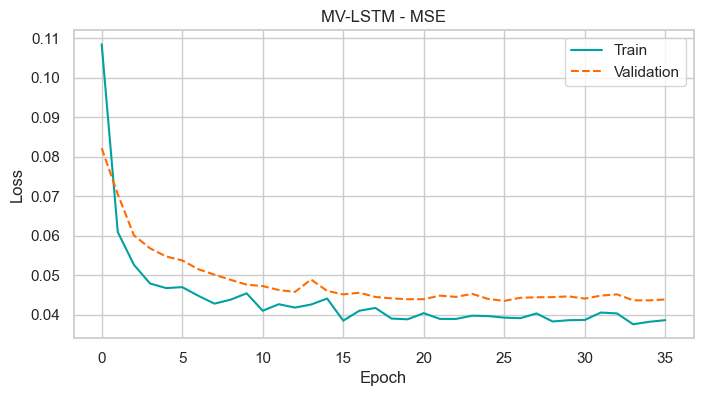

In [40]:
# Es grafica la pèrdua
plot_loss_MSE(history_mv, "MV-LSTM")

S'observa una estabilització cap al 0.04, però la diferència entre les línies denota cert sobreajustament.

In [42]:
y_pred_scaled_MV_LSTM = mv_lstm_model.predict(X_test_MV_LSTM)
y_pred_MV_LSTM = scaler_y.inverse_transform(y_pred_scaled_MV_LSTM)
y_test_inv_MV_LSTM = scaler_y.inverse_transform(y_test_MV_LSTM)

mae = mean_absolute_error(y_test_inv_MV_LSTM, y_pred_MV_LSTM)
print(f"Error Absolut Mitjà (MAE): {mae:.2f}")

mse = mean_squared_error(y_test_inv_MV_LSTM, y_pred_MV_LSTM)
print(f"Error Quadràtic Mitjà (MSE): {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Arrel de l'Error Quadràtic Mitjà (RMSE): {rmse:.2f}")

r2 = r2_score(y_test_inv_MV_LSTM, y_pred_MV_LSTM)
print(f"Coeficient de Determinació (R²): {r2:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Error Absolut Mitjà (MAE): 3.72
Error Quadràtic Mitjà (MSE): 21.05
Arrel de l'Error Quadràtic Mitjà (RMSE): 4.59
Coeficient de Determinació (R²): 0.25


La millora del coeficient de determinació és rellevant, passant de 0.15 a 0.24, el model capta millor la variabilitat.
També baixa lleugerament l'error absolut mitjà, quedant-se en 3.66 pacient per setmana.



Tot i això, el model està lluny de poder fer una predicció sòlida i suficientment variable.

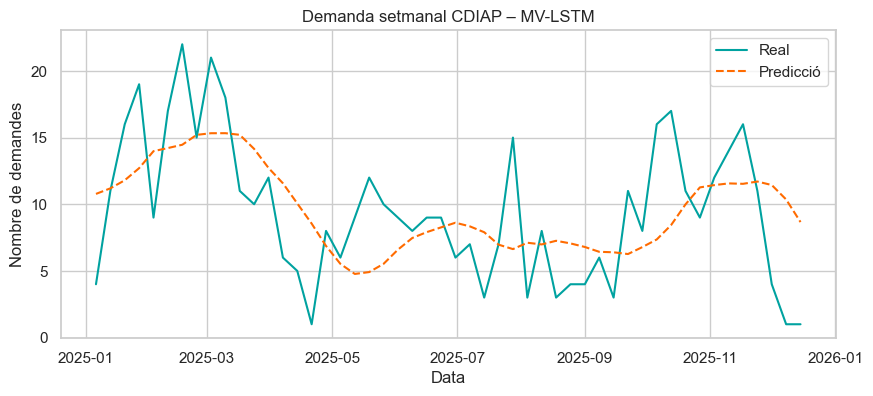

In [44]:
plot_predictions(test_df_MV_LSTM, y_test_inv_MV_LSTM, y_pred_MV_LSTM, window_size, "MV-LSTM")

El model MV-LSTM ha après una tendència conservadora. A diferència de l'ARIMA, que força una estacionalitat rígida basada en cicles històrics, la LSTM prefereix minimitzar l'error quedant-se prop de la mitjana mòbil quan no té prou certesa.

Tot i que la incorporació de variables exògenes (mes i setmana) ha millorat la capacitat explicativa respecte a l'LSTM univariant (augmentant el $R^2$), el rendiment general no supera de forma clara al model SARIMA. Aquesta troballa suggereix que, per al volum actual de dades i la naturalesa de la demanda del CDIAP, els components lineals i estacionals tenen un pes predominant que els models clàssics capturen amb eficiència més alta i menor cost computacional.

Es conclou que, tot i el potencial de l'aprenentatge profund per detectar relacions no lineals, en aquest escenari específic el model SARIMA es manté com l'eina més precisa. No obstant això, l'MV-LSTM estableix una base robusta per a futures expansions on es puguin incloure variables macroeconòmiques o socials amb sèries temporals més llargues.